<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/LSTM-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator

# Data Process

In [19]:
### Import data & dropna
df = pd.read_excel('d1.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])
print(df)

                      Date      NOx
0      2015-01-01 00:15:00  62.2314
1      2015-01-01 00:30:00  75.7350
2      2015-01-01 00:45:00  70.4414
5      2015-01-01 01:30:00  29.6205
6      2015-01-01 01:45:00  53.4148
...                    ...      ...
210426 2020-12-31 22:45:00  11.7719
210427 2020-12-31 23:00:00  25.4470
210428 2020-12-31 23:15:00  34.3861
210429 2020-12-31 23:30:00  47.5379
210430 2020-12-31 23:45:00  65.7220

[204685 rows x 2 columns]


(34176,)


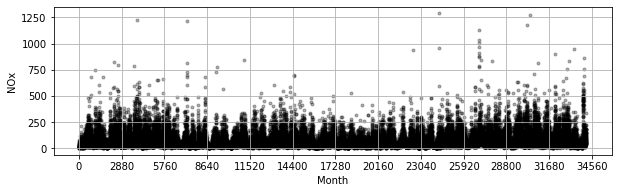

In [20]:
### Data selection(date & NOx)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(data))
plt.scatter(x, data, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(4*24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(data.shape)

(8544,)


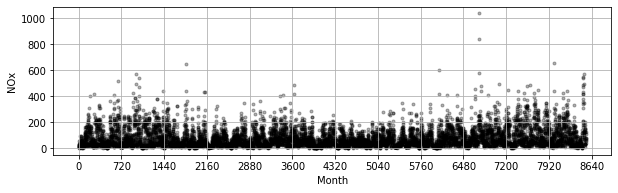

In [21]:
### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)

fig = plt.figure(figsize = (10, 6))
ax2 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(avg))
plt.scatter(x, avg, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(avg.shape)

In [22]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
avg = avg.reshape(len(avg), 1)
data = scaler.fit_transform(avg)
data = data.reshape(len(data),)

print(data.shape)

(8544,)


# Build dataset

In [23]:
### Cofigure
n_in = 7*24
n_out = 36
n_features = 1
n_val = 1

In [24]:
### Build data set
def build_dataset(data):

  X, Y = [], []
  for i in range(data.shape[0]-n_in-n_out+1):
    # X.append(np.array(data.iloc[i:i+n_in]))
    # Y.append(np.array(data.iloc[i+n_in:i+n_in+n_out]))
    X.append(np.array(data[i:i+n_in]))
    Y.append(np.array(data[i+n_in:i+n_in+n_out]))

  return np.array(X), np.array(Y)

data_copy = data.copy()
x, y = build_dataset(data_copy)

print(x.shape, y.shape)

(8341, 168) (8341, 36)


In [25]:
### Split the train and validation datasets
def split_data(x, y):
  
  x_train = x[:-n_val-n_out+1]
  y_train = y[:-n_val-n_out+1]
  x_val = x[-n_val:]
  y_val = y[-n_val:]

  return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = split_data(x, y)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0], y_val.shape[1], 1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(8305, 168, 1) (8305, 36, 1) (1, 168, 1) (1, 36, 1)


# LSTM Construction & Training

In [26]:
### Configure
lr = 1e-4
n_epochs = 800
batchsize = 256
n_neuron = 150

In [27]:
### Contruct the LSTM
def build_lstm():

  model = Sequential()
  # model.add(LSTM(n_neuron, input_shape=(n_in, n_features)))
  model.add(LSTM(n_neuron, input_shape=(n_in, n_features), return_sequences=True))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(n_out))
  #model.add(Activation("sigmoid"))
  model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss='mae')

  return model

Epoch 1/800
33/33 [==============================] - 7s 131ms/step - loss: 0.0677 - val_loss: 0.0453
Epoch 2/800
33/33 [==============================] - 3s 105ms/step - loss: 0.0534 - val_loss: 0.0412
Epoch 3/800
33/33 [==============================] - 3s 105ms/step - loss: 0.0509 - val_loss: 0.0439
Epoch 4/800
33/33 [==============================] - 3s 105ms/step - loss: 0.0503 - val_loss: 0.0470
Epoch 5/800
33/33 [==============================] - 3s 104ms/step - loss: 0.0499 - val_loss: 0.0510
Epoch 6/800
33/33 [==============================] - 3s 104ms/step - loss: 0.0495 - val_loss: 0.0555
Epoch 7/800
33/33 [==============================] - 3s 105ms/step - loss: 0.0492 - val_loss: 0.0603
Epoch 8/800
33/33 [==============================] - 3s 104ms/step - loss: 0.0489 - val_loss: 0.0679
Epoch 9/800
33/33 [==============================] - 3s 104ms/step - loss: 0.0485 - val_loss: 0.0741
Epoch 10/800
33/33 [==============================] - 3s 104ms/step - loss: 0.0480 - val_lo

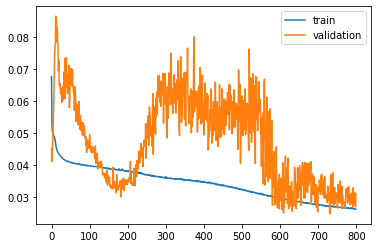

In [28]:
### Training LSTM
def model_fit(x_train, y_train, x_val, y_val):
    
    model = build_lstm()

    my_callbacks = [ModelCheckpoint(filepath='my_model.h5', save_best_only=True)]
    # my_callbacks = [EarlyStopping(patience=100), ModelCheckpoint(filepath='my_model.h5', save_best_only=True), ReduceLROnPlateau(factor = 0.1, patience = 50)]
    history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, callbacks=my_callbacks, validation_data=(x_val, y_val))
    # history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, validation_data=(x_val, y_val))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

model = model_fit(x_train, y_train, x_val, y_val)
model = load_model('my_model.h5')

# Results visualization & Analysis

In [29]:
### Prediction
Prediction = model.predict(x_val)
Prediction = scaler.inverse_transform(Prediction)
Prediction = Prediction.reshape(n_out*n_val,)
Prediction

array([186.16603 , 176.69864 , 174.08897 , 166.33179 , 152.14894 ,
       131.13405 ,  98.679405,  71.21165 ,  51.342663,  37.634098,
        28.52724 ,  20.983728,  18.027796,  20.310526,  23.949207,
        32.828373,  44.751587,  63.582615,  86.57469 , 114.10923 ,
       142.99258 , 161.45006 , 156.37605 , 142.54335 , 137.25462 ,
       141.65779 , 156.35587 , 160.05235 , 151.3059  , 128.61348 ,
       106.108475,  84.69007 ,  70.18706 ,  62.86584 ,  57.03438 ,
        51.20673 ], dtype=float32)

In [30]:
### Truth
y_val = y_val.reshape(1,n_out*n_val)
Truth = scaler.inverse_transform(y_val)[0]
Truth.shape

(36,)

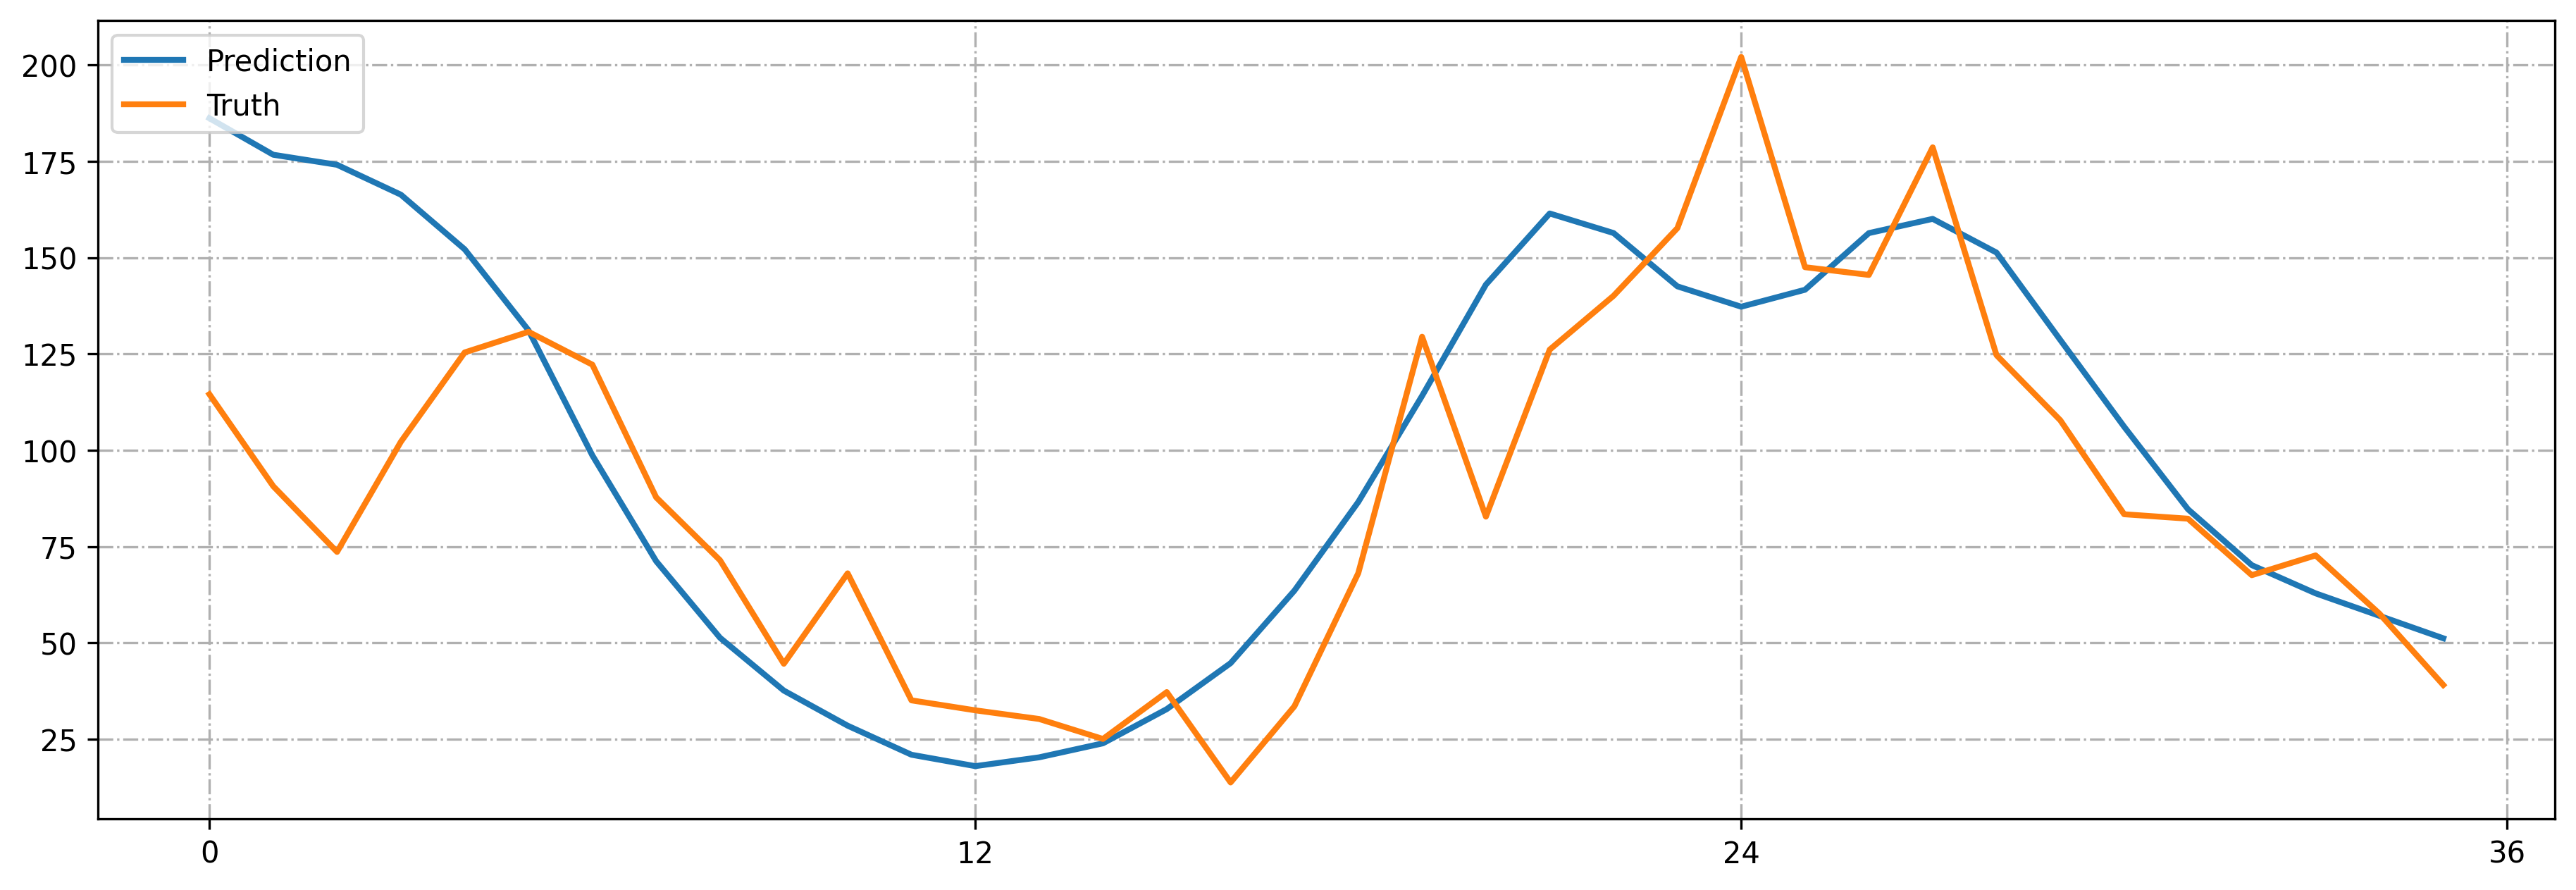

In [31]:
### Visualization
x = [x for x in range(n_out*n_val)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(12)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [32]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE)
print('Test RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction)
print('Test MAE: %.3f' %MAE)

Test RMSE: 35.451
Test MAE: 25.550


# Others

In [33]:
##################################### Box-plot #####################################
# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
# d1.plot.box(vert=False, grid = True,color = color,ax = ax1,label = 'NOx data')

# s = data.describe()
# print(s)
# print('------')
# q1 = s['NOx'][4]
# q3 = s['NOx'][6]
# iqr = q3 - q1
# min = q1 - 1.5*iqr
# max = q3 + 1.5*iqr
# print('IQR：%.3f，min：%.3f，max：%.3f' % (iqr,min,max))

# ax2 = fig.add_subplot(3,1,3)
# error = d1['NOx'][(d1['NOx'] < min) | (d1['NOx'] > max)]
# data_c = d1['NOx'][(d1['NOx'] >= min) & (d1['NOx'] <= max)]
# print('The number of outliers: %i' % len(error)) 
# plt.scatter(data_c.index,data_c,color = 'k',marker='.',alpha = 0.3)
# plt.scatter(error.index,error,color = 'r',marker='.',alpha = 0.5)
# plt.grid()

In [34]:
##################################### Normal-distribution(3 sigma) #####################################
# u = d1['NOx'].mean() 
# std = float(d1['NOx'].std())
# stats.kstest(d1['NOx'], 'norm', (u, std))
# print('Mean：%.3f，Std：%.3f' % (u, std))

# sigma = 3
# fig = plt.figure(figsize = (10,6))
# d1.plot(kind = 'kde',grid = True,style = '-k',title = 'Density curve')
# plt.axvline(sigma*std,color='r',linestyle="--",alpha=0.8) 
# plt.axvline(-sigma*std,color='r',linestyle="--",alpha=0.8)

# error = d1['NOx'][np.abs(d1['NOx'] - u) > sigma*std]
# data_c = d1['NOx'][np.abs(d1['NOx'] - u) <= sigma*std]
# print('The number of outliers: %i' % len(error))
# ax1 = fig.add_subplot(3,1,1)
# plt.scatter(data_c.index,data_c,color = 'k',marker='.',alpha = 0.3)
# plt.scatter(error.index,error,color = 'r',marker='.',alpha = 0.5)
# plt.grid()